In [1]:
#Uncomment and run the following line to install the lifelines package
#!pip install lifelines


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import lifelines #imported lifelines to get dataset overview 
from lifelines import datasets, CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler #for preproceesing data

# Assignment 1: Survival Analysis

## Setup

As is common in medical data, the dataset contains missing values. The following code performs some basic imputation to address this. More on imputation in Module 7!

In [40]:
#view dataset to better understand variables 
lifelines.datasets.load_lung()

#228 rows x10 columns 

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
223,1.0,188,0,77,1,1.0,80.0,60.0,NaN,3.0
224,13.0,191,0,39,1,0.0,90.0,90.0,2350.0,-5.0
225,32.0,105,0,75,2,2.0,60.0,70.0,1025.0,5.0
226,6.0,174,0,66,1,1.0,90.0,100.0,1075.0,1.0


In [41]:
# Load the lung dataset and perform median and mode imputation

lung_df = datasets.load_lung()

continous_columns = ["inst", "time", "age", "ph.karno", "pat.karno", "meal.cal", "wt.loss"]
median_imputer = SimpleImputer(strategy='median', missing_values=np.nan)
median_imputed_values = median_imputer.fit_transform(lung_df[continous_columns])

categorical_columns = ["sex", "ph.ecog"]
mode_imputer = SimpleImputer(strategy='most_frequent')
mode_imputed_values = mode_imputer.fit_transform(lung_df[categorical_columns])

lung_df[continous_columns] = median_imputed_values
lung_df[categorical_columns] = mode_imputed_values

## Problem 1

### Data Exploration

* Plot a histogram of time to observed failure events (mortality) and indicate how many events were censored.
* Report the number of people who did not experience the failure event (i.e., the number who are still “surviving” by the end of the study).

In [42]:
#counts number of patient who survived( status 0) and died (status 1)
lung_df['status'].value_counts()

status
1    165
0     63
Name: count, dtype: int64

Text(0.5, 1.0, 'Mortality')

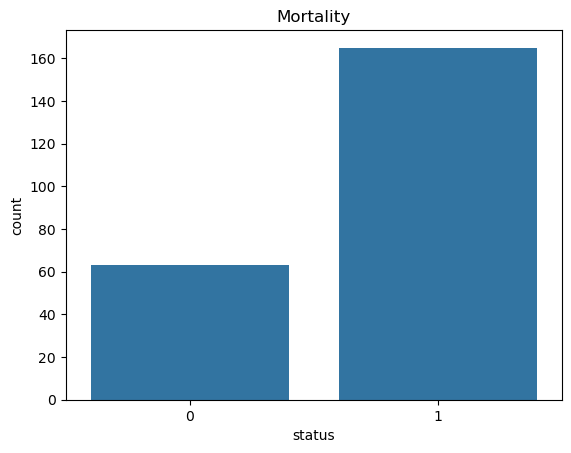

In [43]:
#status 0 = censored (alive), 1 = death
#histogram plot 
sns.countplot(data = lung_df, x= 'status')
plt.title('Mortality')

Number of survivors after the end of the study:  63
   inst    time  status   age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  \
0   3.0   306.0       1  74.0  1.0      1.0      90.0      100.0    1175.0   
1   3.0   455.0       1  68.0  1.0      0.0      90.0       90.0    1225.0   
2   3.0  1010.0       0  56.0  1.0      0.0      90.0       90.0     975.0   
3   5.0   210.0       1  57.0  1.0      1.0      90.0       60.0    1150.0   
4   1.0   883.0       1  60.0  1.0      0.0     100.0       90.0     975.0   

   wt.loss     years  
0      7.0  0.838356  
1     15.0  1.246575  
2     15.0  2.767123  
3     11.0  0.575342  
4      0.0  2.419178  
Number of survivors after the end of the study:  63


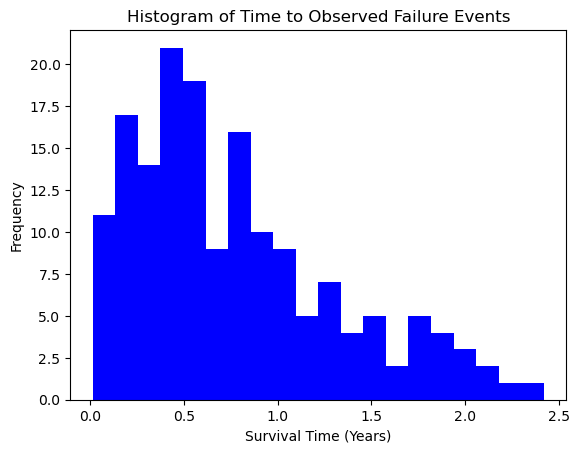

In [45]:
# Plot histogram of time to observed events(mortality) and censored(alive)

Patients_alive = lung_df[lung_df['status'] == 0]
Patients_dead = lung_df[lung_df['status'] == 1]
#Number of survivers 
number_censored = len(Patients_alive)
print('Number of survivors after the end of the study: ',number_censored )
#convert the survival time from days to years for better visualization
lung_df['years'] = lung_df['time']/365

# Verify that 'years' column is added correctly
print(lung_df.head())

print('Number of survivors after the end of the study: ',number_censored )
#plot histogram over years
plt.hist(Patients_dead['years'], bins=20, color = 'blue')
plt.title('Histogram of Time to Observed Failure Events')
plt.xlabel('Survival Time (Years)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


### Kaplan-Meier Survival Plot

* Generate a Kaplan-Meier survival plot to show the probability of survival over time for the entire stude population.


* Create separate Kaplan-Meier plots for each gender to explore any differences in survival rates.

* What do you conclude from these results?

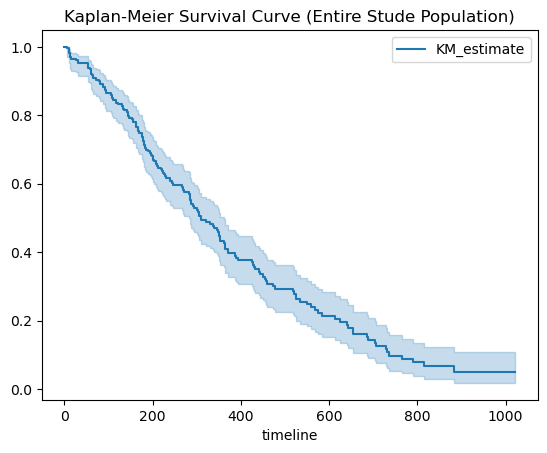

In [46]:
# Kaplan-meier Survival Plot
kmf = KaplanMeierFitter()

# Kaplan-Meier curve for entire population
kmf.fit(lung_df['time'], event_observed=lung_df['status'])
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve (Entire Stude Population)")
plt.show()



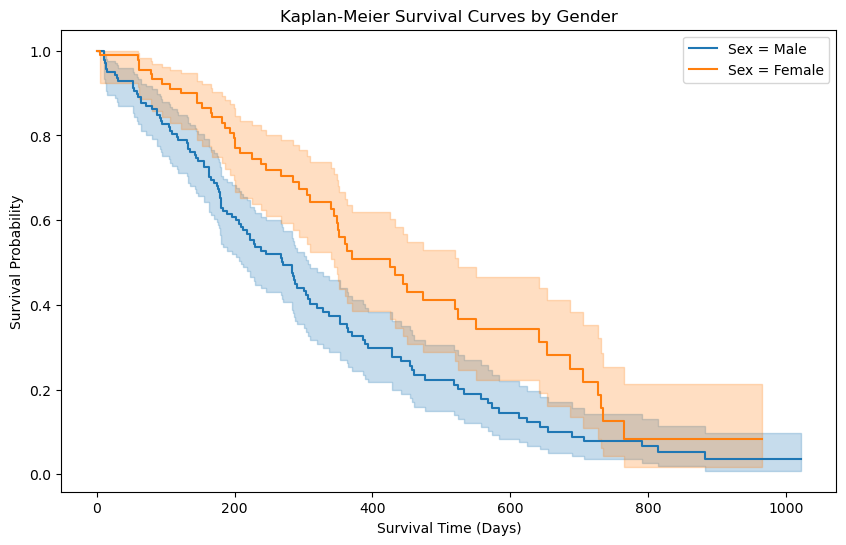

In [47]:
#Kaplan-Meier Surivavl plot 
#Kaplan-Meier estimator estimates survival probability over time, handling censored data.

# I first create a plot axis
fig, ax = plt.subplots(figsize=(10, 6))

# next I create a Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Group the data by 'sex' and plot for each group
for sex, df in lung_df.groupby('sex'):
    kmf.fit(df['time'], event_observed=df['status'])
    kmf.plot(label='Sex = %s' % ('Male' if sex == 1 else 'Female'), ax=ax)

# Add labels and title
ax.set_title('Kaplan-Meier Survival Curves by Gender')
ax.set_xlabel('Survival Time (Days)')
ax.set_ylabel('Survival Probability')

# Show the plot
plt.legend()
plt.show()


The Kaplan-Meier curve helps us visualize how survival probability changes over time in a study group. It shows the likelihood of survival as time progresses, while also accounting for individuals who are lost to follow-up or still alive at the end of the study.When the curve flattens, it means that the remaining individuals are surviving longer, and no new deaths are occurring. From the plot, we can observe that the female survival curve is higher than the male's, suggesting that females may have a higher survival probability compared to males. Around 2.19 years (800 days), the female curve becomes flat, indicating that most females have survived past that point. The male survival curve flattens around 3 years (900 days), suggesting that most males who survived until then have reached the end of the study or the event of interest. 

## Problem 2

### Fitting the Cox Proportional Hazards Model

* Split the data so that 30% of it is used for testing and the remaining 70% is used to train the model.
* Fit a Cox Proportional Hazards (CPH) model using the lifelines package that estimates survival time conditioned on patient covariates. 
* Report any modeling choices you have made, such as the selection of hyperparameters and representation of discrete variables
* Report the CPH model coefficients. What does this say about the contribution of the different variables to the model?

In [48]:
#1.split dataset in 30% for testing and 70% for training 
#we first drop the 2 columns we are more interested into such as time and status 

#check if dropping the column is working correclty 
#x=lung_df.drop(columns = 'status', axis =1)
#print(x)

#dropping status and time 
X = lung_df.drop( columns = ['time','status'])
Y = lung_df[['time','status']]

print('X', X)
print('Y: ',Y)

X      inst   age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  wt.loss  \
0     3.0  74.0  1.0      1.0      90.0      100.0    1175.0      7.0   
1     3.0  68.0  1.0      0.0      90.0       90.0    1225.0     15.0   
2     3.0  56.0  1.0      0.0      90.0       90.0     975.0     15.0   
3     5.0  57.0  1.0      1.0      90.0       60.0    1150.0     11.0   
4     1.0  60.0  1.0      0.0     100.0       90.0     975.0      0.0   
..    ...   ...  ...      ...       ...        ...       ...      ...   
223   1.0  77.0  1.0      1.0      80.0       60.0     975.0      3.0   
224  13.0  39.0  1.0      0.0      90.0       90.0    2350.0     -5.0   
225  32.0  75.0  2.0      2.0      60.0       70.0    1025.0      5.0   
226   6.0  66.0  1.0      1.0      90.0      100.0    1075.0      1.0   
227  22.0  58.0  2.0      1.0      80.0       90.0    1060.0      0.0   

        years  
0    0.838356  
1    1.246575  
2    2.767123  
3    0.575342  
4    2.419178  
..        ...  
223  0.51

Data standardization

In [49]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [50]:
# Exclude 'sex' from standardization(needed for concordance by gender)
numeric_columns = lung_df.drop(columns=['sex']).select_dtypes(include=['float', 'int']).columns
standardized_data = (lung_df[numeric_columns] - lung_df[numeric_columns].mean()) / lung_df[numeric_columns].std()

# Reattach 'sex' to the standardized data
standardized_data['sex'] = lung_df['sex']


In [51]:
#standardized_data = scaler.transform(X)
#print(standardized_data)

In [52]:
X = standardized_data
Y = lung_df[['time','status']]

print(X.shape)
print(Y.columns)

(228, 11)
Index(['time', 'status'], dtype='object')


In [53]:
#try1

# 'lung_df' has columns like ['inst', 'time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno', ...]
# The 'standardized_data' should only have the feature columns for X (excluding 'time' and 'status').

# Ensure standardized_data has the correct column names for features (excluding 'time' and 'status')
feature_columns = ['inst','age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss', 'years']  # List of feature column names
standardized_data_df = pd.DataFrame(standardized_data, columns=feature_columns)  # Create DataFrame with proper column names

# now split the dataset into training and testing
from sklearn.model_selection import train_test_split

X = standardized_data_df  # Features (standardized)
Y = lung_df[['time', 'status']]  # Target (time and status)

# split dataset into 70% for training and 30% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# convert NumPy arrays (X_train, X_test) to DataFrames and assign the correct column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# combine X_train_df and Y_train into one DataFrame for training, and X_test_df and Y_test for testing
train_data = pd.concat([X_train_df.reset_index(drop=True), Y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test_df.reset_index(drop=True), Y_test.reset_index(drop=True)], axis=1)

#after splitting both X_train/X_test and Y_train/Y_test  may have misaligned indices.resetting the indecis ensures proper alignment for concatenation
#I used concatanation to combine the features X_train and X_test_df with the outcomes Y_train and Y_test along axis=1 to create training and testing dataset


# Check if the columns now have the proper names
print(train_data.columns)  # This should print: ['age', 'sex', 'ph.ecog', 'ph.karno', ... , 'time', 'status']


Index(['inst', 'age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal',
       'wt.loss', 'years', 'time', 'status'],
      dtype='object')


In [54]:
#train_data.columns

#train data contains 70% of the rows with 11 columns(9features+time+status)
#test data contains 30% of the rows with 11 columns(9features+time+status)

print(train_data.shape)
print(test_data.shape)

(159, 11)
(69, 11)


In [55]:
#2.Fit a Cox Proportional Hazards (CPH) model using the lifelines package that estimates survival time conditioned on patient covariates.
cph = CoxPHFitter()
cph.fit(train_data,'time', 'status')

# Print summary of the model
cph.print_summary()
#fitting = cph.fit(df,'status','time')

C:\Users\user\.conda\envs\dml\Lib\site-packages\lifelines\utils\__init__.py:1163: ConvergenceWarning: Column years has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\user\.conda\envs\dml\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 159 total observations, 43 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 159
number of events observed = 116
   partial log-likelihood = -196.22
         time fit was run = 2024-11-22 17:19:20 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
inst      -0.19      0.83      0.11           -0.40            0.02                0.67                1.03
age        0.09      1.10      0.11           -0.13            0.31                0.88                1.37
sex       -0.38      0.68      0.22           -0.82            0.06                0.44                1.06
ph.ecog    0.03      1.04      0.17           -0.29            0.36                0.75                1.43
ph.karno  -0.08      0.92      0.17           -0.41            0.24                0.67                1.28
pat.karno  0.01      1.01      0.12           -0.24            0.25                0.79                1.28
meal.cal   0.09      1.09      0.11           -0.13            0.31                0.88                1.36
wt.loss    0.00      1.00      0.10           -0.19            0.20                0.83                1.22
years     -9.26      0.00      0.91          -11.05           -7.47                0.00                0.00

           cmp to      z      p  -log2(p)
covariate                                
inst         0.00  -1.73   0.08      3.59
age          0.00   0.83   0.41      1.30
sex          0.00  -1.71   0.09      3.52
ph.ecog      0.00   0.21   0.83      0.26
ph.karno     0.00  -0.49   0.63      0.68
pat.karno    0.00   0.04   0.97      0.05
meal.cal     0.00   0.79   0.43      1.22
wt.loss      0.00   0.04   0.97      0.05
years        0.00 -10.15 <0.005     77.95
---
Concordance = 0.99
Partial AIC = 410.43
log-likelihood ratio test = 580.90 on 9 df
-log2(p) of ll-ratio test = 393.92

Modeling Choices

Hyperparameters: 
The CoxPHFitter does not require many hyperparameters. I used the default settings.

Representation of Discrete Variables:
In the model, categorical variables such as sex were represented as binary variables, while continuous variables were standardized to have a mean of 0 and a standard deviation of 1. Standardization was necessary because features often have different scales (e.g., age in years vs. weight loss in pounds), and without standardization, variables with larger scales could dominate the model. By rescaling all features, standardization ensured that each variable contributed equally, improved the model’s numerical stability, and made the optimization process more robust. Additionally, it enhanced the interpretability of the Cox model by allowing easier comparison of coefficients across variables.

In [18]:
#Print parameters 
print('Parameters cph: ', cph.params_)


Parameters cph:  covariate
inst        -0.188685
age          0.093143
sex         -0.383267
ph.ecog      0.034813
ph.karno    -0.080810
pat.karno    0.005459
meal.cal     0.087813
wt.loss      0.004167
years       -9.258872
Name: coef, dtype: float64


Results interpretation:

From the results we can see that each coefficient(and their significance (p-values)) quantifies the relationship between the covariate and the hazard( such as the risk of the event happening).Positive coefficients like age,ECOG performance score as rated by the physician and Calories consumed at meals icrease the hazard and reduce the survival probability.On the other hand negative coefficients like years,Institution code,Karnofsky performance score rated by patient and by physician,Weight loss in last six months decrease the hazard, this means they increase the survival probability. In addition to this the larger is the absolute value the stronger is the effect.For instance years has value  -9.258872, this means that longer survival times (years) leads to higher survival probability.

In [19]:
print('Baseline Hazard: ', cph.baseline_hazard_)

Baseline Hazard:          baseline hazard
5.0        1.165067e-07
11.0       3.777971e-07
13.0       4.425725e-07
15.0       3.857306e-07
26.0       5.007611e-07
...                 ...
840.0      0.000000e+00
883.0      4.895720e+10
965.0      0.000000e+00
1010.0     0.000000e+00
1022.0     0.000000e+00

[137 rows x 1 columns]


The baseline hazard represents the risk of failure over time for a baseline individual (all covariates = 0).These values are used to calculate the overall hazard for any individual by combining the baseline hazard with the individual's covariates using the formula:
h(t)=h0(t)⋅e^∑coefi⋅covariatei

Very small values (e.g., 1.165067e-07) indicate a low risk of failure at that time.
Large values (e.g., 4.895720e+10 at 883 days) reflect a high risk of failure for individuals with baseline characteristics.
Zero values (0.000000e+00) occur when no events are observed at that time point.

### Evaluation

* Look up the "concordance index" metric, for example at https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html.
* Report the test-set concordance index and how to interpret the value.

* What is the model's partial log-likelihood score on the training and test sets?

* Predict the survival function for individuals in the test set at all event times observed in the data using the fitted CPH model. 
* Compute the estimated survival function for individuals in the test set at all event times observed in the data using the fitted CPH model. Then compute the marginal survival function based on the individual survival curves and plot it. Compare this estimate to the Kaplan-Meier survival curves.
  * How well do the model’s predictions align with observed survival rates? 
  * The CPH model is semi-parametric. In your application, how was the full survival function (or hazard) computed?
* Compare the model’s performance (concordance index & partial log-likelihood) across different groups (e.g., by gender) to assess if there are performance differences.
  * If there are differences in performance for different groups, what are some ways to remedy them?

Concordance index is a metric used in survival analysis to measure the predictive accuracy of a model. It evaluates how well the predicted survival times( or risk score) from a model align with the actual observed survival data.The index ranges from 0 to 1 and where 1 represents perfect concordance while 0.5 represents random predicting from the model. The 

In [20]:
1.#Concordance index 
# Combine test covariates and survival data
test_data = X_test_df.copy()
test_data['time'] = Y_test['time']
test_data['status'] = Y_test['status']

# Concordance index
c_index = cph.concordance_index_
print(f"Concordance Index (Test Set): {c_index}")


Concordance Index (Test Set): 0.992359413202934


The concordance index measures how well the model predicts survival order: a value close to 1 indicates perfect prediction. A value close to 0.5 indicates random guessing. As we can see our concordance index for the test set is 0.99 which is very close to 1. This means that our model is very good at making predictions.

In [21]:
#Partial log-likelihood 
# Compute partial log-likelihood on the training set
train_log_likelihood = cph.log_likelihood_

# Compute partial log-likelihood on the test set
test_log_likelihood = cph.score(test_data)
print(f"Training Partial Log-Likelihood: {train_log_likelihood}")
print(f"Test Partial Log-Likelihood: {test_log_likelihood}")


Training Partial Log-Likelihood: -196.21501882354755
Test Partial Log-Likelihood: -0.905352691442037


The partial  Log-Likelihood is a key metric to evaluate performance of survival models. A higher, less negative, value indicates a better model fit. the training partial log-likelihood is considerably negative ( -196.215),suggesting that the model is capturing the data well on the training set. 

The test partial log-Likelihood is significantly less negative, which suggets that the model may not generalize well on unseen data. The reults shows that model tuning and regularization might be needed to reduce overfitting.

In [22]:
#3.Predict survival functions for each individual in the test set
survival_functions = cph.predict_survival_function(test_data)


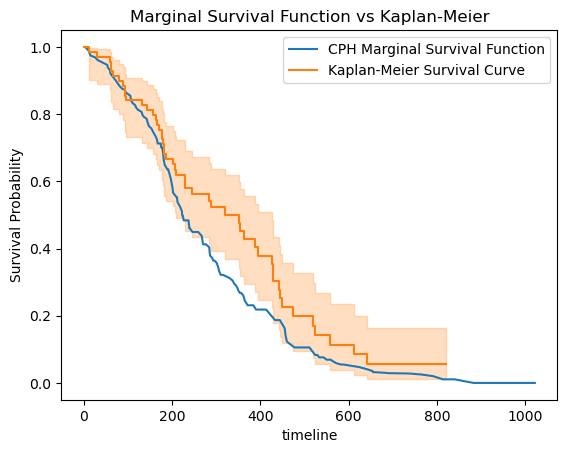

In [23]:
# Compute the marginal survival function
marginal_survival = survival_functions.mean(axis=1)

# Plot the marginal survival function
plt.plot(marginal_survival, label='CPH Marginal Survival Function')
plt.title('Marginal Survival Function vs Kaplan-Meier')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')

# Add Kaplan-Meier curve
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(Y_test['time'], Y_test['status'])
kmf.plot(label='Kaplan-Meier Survival Curve', ax=plt.gca())

plt.legend()
plt.show()


In [24]:
# check unique values in 'sex' column
print("Unique values in 'sex':", test_data['sex'].unique())

# now we filter by gender
test_male = test_data[test_data['sex'] == 1]  # Update condition if unique values differ
test_female = test_data[test_data['sex'] == 2]  # Update condition if unique values differ

# confirm subsets are not empty
print("Male subset shape:", test_male.shape)
print("Female subset shape:", test_female.shape)

# with this we ompute concordance index and log-likelihood if subsets are non-empty
if not test_male.empty:
    c_index_male = concordance_index(test_male['time'], -cph.predict_partial_hazard(test_male), test_male['status'])
    log_likelihood_male = cph.score(test_male)
    print(f"Concordance Index (Male): {c_index_male}, Partial Log-Likelihood (Male): {log_likelihood_male}")
else:
    print("No male data available in the test set.")

if not test_female.empty:
    c_index_female = concordance_index(test_female['time'], -cph.predict_partial_hazard(test_female), test_female['status'])
    log_likelihood_female = cph.score(test_female)
    print(f"Concordance Index (Female): {c_index_female}, Partial Log-Likelihood (Female): {log_likelihood_female}")
else:
    print("No female data available in the test set.")


Unique values in 'sex': [1. 2.]
Male subset shape: (45, 11)
Female subset shape: (24, 11)
Concordance Index (Male): 0.9884318766066839, Partial Log-Likelihood (Male): -0.7457837813493833
Concordance Index (Female): 0.9896907216494846, Partial Log-Likelihood (Female): -0.36497555965170214


### Impact of Dropping Censored 

* Investigate how the model results change if you only use uncensored samples when fitting the model.

In [25]:
#to avoid problems with convergence of the optimization algorithm (Newton-Raphson) used to fit the Cox Proportional Hazards model
#i dropped years,which is very similar to column time

train_data.describe()
train_data =train_data.drop(columns = ['years'])

Model Trained on Full Data
Concordance Index: 0.989, Log-Likelihood: -0.905

Model Trained on Uncensored Data Only
Concordance Index: 0.564, Log-Likelihood: -2.333


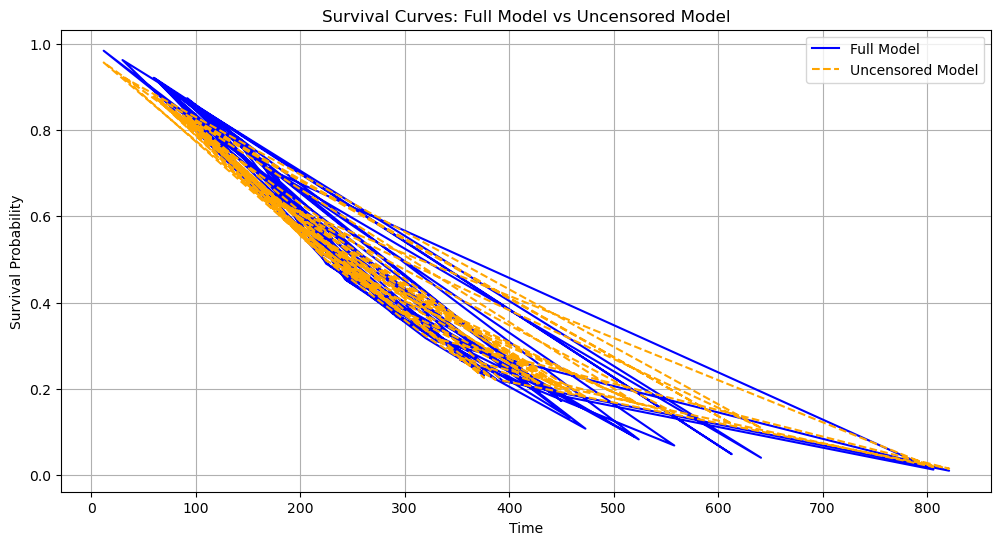

In [26]:
# filter out censored data (status == 0)

uncensored_train_data = train_data[train_data['status'] == 1]

# fit Cox model to uncensored data
cph_uncensored = CoxPHFitter()
cph_uncensored.fit(uncensored_train_data, duration_col='time', event_col='status')

# evaluate the refitted model on the full test set
c_index_uncensored = concordance_index(test_data['time'], -cph_uncensored.predict_partial_hazard(test_data), test_data['status'])
log_likelihood_uncensored = cph_uncensored.score(test_data)

# original model evaluation (for comparison)
c_index_full = concordance_index(test_data['time'], -cph.predict_partial_hazard(test_data), test_data['status'])
log_likelihood_full = cph.score(test_data)

# print the results
print("Model Trained on Full Data")
print(f"Concordance Index: {c_index_full:.3f}, Log-Likelihood: {log_likelihood_full:.3f}\n")

print("Model Trained on Uncensored Data Only")
print(f"Concordance Index: {c_index_uncensored:.3f}, Log-Likelihood: {log_likelihood_uncensored:.3f}")

# predict and plot survival curves for comparison
time_points = test_data['time'].unique()
survival_full = cph.predict_survival_function(test_data, times=time_points).mean(axis=1)
survival_uncensored = cph_uncensored.predict_survival_function(test_data, times=time_points).mean(axis=1)

# plot survival curves
plt.figure(figsize=(12, 6))
plt.plot(time_points, survival_full, label="Full Model", linestyle='-', color='blue')
plt.plot(time_points, survival_uncensored, label="Uncensored Model", linestyle='--', color='orange')
plt.title("Survival Curves: Full Model vs Uncensored Model")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


The concordance index is  0.989 for the model trained on Full data, which is very close to to 1.0 (perfect prediction).While it reaches only 0.564 for the model Trained on Uncensored Data Only. Higher values indicate better predictive accuracy.
The log-likelihood provides a measure of model fit, with higher (less negative) values indicating a better fit.
When censoring is accounted for, the model performs better, with Log-Likelihood: -0.905, as it reflects the real-world scenario where not all patients' outcomes are observed. If we remove censored data, the model will likely overfit to the observed outcomes, but it will not generalize as well. This is an important consideration for survival analysis models.

## Problem 3

### Effects of additional censoring

* Censor a random subset of uncensored samples (40% of uncensored ones) by changing the status variable. Now, refit the Kaplan-Meier estimator from Problem 1 and compare the results. What do you find? Explain the pattern using the definition of the KM estimator. 

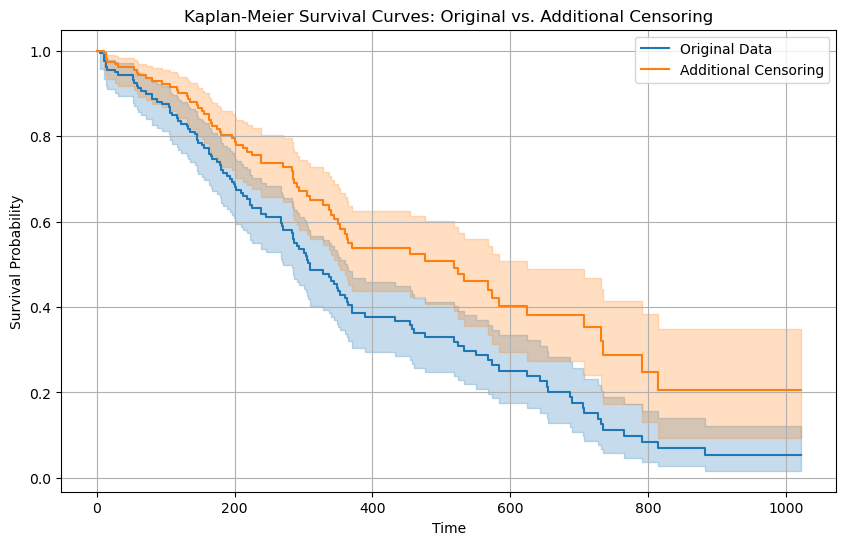

In [27]:
# filter out censored data (status == 0)

# identify uncensored samples and apply additional censoring
uncensored_data = train_data[train_data['status'] == 1]
num_to_censor = int(0.4 * len(uncensored_data))  # 40% of uncensored samples

# randomly select indices to censor
np.random.seed(42)  # Ensure reproducibility
censored_indices = np.random.choice(uncensored_data.index, num_to_censor, replace=False)

# create a new dataset with additional censoring
censored_data = train_data.copy()
censored_data.loc[censored_indices, 'status'] = 0  # Change status to 'censored'

# fit Kaplan-Meier estimators
kmf_original = KaplanMeierFitter()
kmf_censored = KaplanMeierFitter()

# fit the estimators
kmf_original.fit(durations=train_data['time'], event_observed=train_data['status'], label='Original Data')
kmf_censored.fit(durations=censored_data['time'], event_observed=censored_data['status'], label='Additional Censoring')

# plot and compare survival curves
plt.figure(figsize=(10, 6))
kmf_original.plot_survival_function(ci_show=True)
kmf_censored.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves: Original vs. Additional Censoring")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


The survival curve with additional censoring is higher than the original survival curve because fewer events are recorded. In the Kaplan-Meier (KM) estimator, survival probabilities decrease only when events happen. With additional censoring, fewer events (di) are observed, so the survival probability decreases more slowly.
This makes it look like more individuals survive longer, even though some events are simply being treated as censored. As a result, the survival curve flattens earlier and gives an overestimate of survival probabilities, especially at later times when most individuals are censored.
In short, additional censoring causes the KM estimator to overestimate survival probabilities because it reduces the number of recorded events, leading to less accurate results over time.

### Limitations of the CPH model

* The Cox proportional hazards model assumes that the covariate scaling factor has a particular parametric form, $\exp(\theta^\top x)$ . This form can be ill-suited if there are strong covariate "interactions". If you have not come across the concept "covariate interaction" or "feature interaction" before, look it up, for example, [here](https://christophm.github.io/interpretable-ml-book/interaction.html). 
  * Why would feature interactions make the CPH model unsuitable? Give a general argument and an example. 
  * By inspecting the lung cancer data set features, are there possible feature interactions that could affect lung cancer survival? How would you test your hypothesis?
* If you suspect that there is an important feature interaction in your survival problem, how could you handle it?
  * Suggest a small modification to the procedure from Problem 2 that works if you know which features are likely to interact. 
  * Suggest a general modeling strategy that could work even if the interactions are unknown.

In [34]:

# create interaction term in the full dataset
lung_df['age_ph.ecog_interaction'] = lung_df['age'] * lung_df['ph.ecog']

# split the data again to ensure train_data contains the new column
train_data = lung_df.sample(frac=0.8, random_state=42)  # 80% training data
test_data = lung_df.drop(train_data.index)              # Remaining 20% for testing

# fit the Cox Proportional Hazards model with the interaction term
cph.fit(train_data[['age', 'ph.ecog', 'age_ph.ecog_interaction', 'time', 'status']], 'time', 'status')
# Create interaction term in the full dataset
lung_df['age_ph.ecog_interaction'] = lung_df['age'] * lung_df['ph.ecog']



In [35]:
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 182 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 182
number of events observed = 135
   partial log-likelihood = -572.68
         time fit was run = 2024-11-22 17:03:55 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                
age                      0.04      1.04      0.02           -0.00            0.08                1.00                1.08
ph.ecog                  2.24      9.43      1.02            0.25            4.23                1.29               69.02
age_ph.ecog_interaction -0.03      0.97      0.02           -0.06            0.00                0.94                1.00

                         cmp to     z    p  -log2(p)
covariate                                           
age                        0.00  1.94 0.05      4.24
ph.ecog                    0.00  2.21 0.03      5.21
age_ph.ecog_interaction    0.00 -1.79 0.07      3.77
---
Concordance = 0.62
Partial AIC = 1151.36
log-likelihood ratio test = 18.77 on 3 df
-log2(p) of ll-ratio test = 11.68

In [36]:
concordance = cph.concordance_index_
print(f"Concordance Index: {concordance}")


Concordance Index: 0.6186936763459909


<Axes: xlabel='log(HR) (95% CI)'>

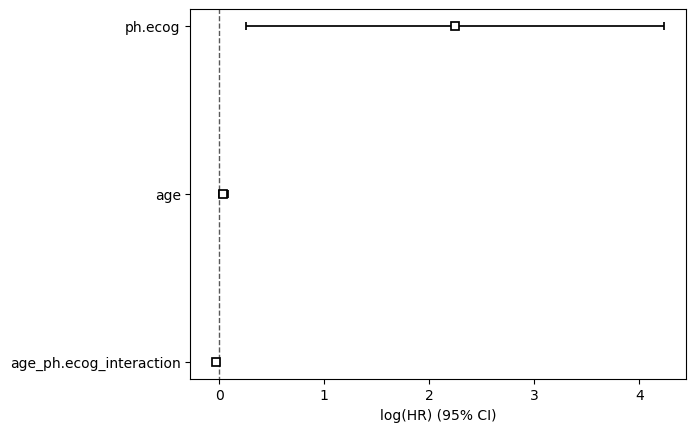

In [37]:
cph.plot()


In [32]:
# Model without interaction
cph_no_interaction = CoxPHFitter()
cph_no_interaction.fit(train_data[['age', 'ph.ecog', 'time', 'status']], 'time', 'status')
print(f"Log-Likelihood without interaction: {cph_no_interaction.log_likelihood_}")
print(f"Log-Likelihood with interaction: {cph.log_likelihood_}")


Log-Likelihood without interaction: -574.3054728204334
Log-Likelihood with interaction: -572.6810106455116


The model's concordance index is 0.62, which indicates moderate predictive accuracy. A value of 1.0 represents perfect prediction, while 0.5 suggests no better than random guessing. This shows the model captures some survival trends but has room for improvement.Coefficients and Their Interpretation:
Age: Coefficient: 0.04, Hazard Ratio (exp(coef)): 1.04,Interpretation: For every one-unit increase in age, the hazard (risk of the event) increases by 4%. While significant, its effect is relatively small.
ph.ecog (Performance Status): Coefficient: 2.24, Hazard Ratio (exp(coef)): 9.43,Interpretation: This variable has a substantial effect on survival. Higher values (worse performance status) are associated with significantly higher risk.
Age-Performance Status Interaction: Coefficient: -0.03, Hazard Ratio (exp(coef)): 0.97, Interpretation: The negative coefficient suggests that the impact of age on survival weakens as performance status worsens. This interaction indicates that age and performance status are not independent in their effects on survival.

Model Evaluation Metrics:Partial AIC: 1151.36 indicates the trade-off between model complexity and goodness-of-fit. A lower AIC is preferred, but this value is context-dependent.
Log-Likelihood Ratio Test: Statistic: 18.77 on 3 degrees of freedom, p-value: Significant (-log2(p) = 11.68),Interpretation: The test confirms that the included variables contribute significantly to the model’s predictive ability.The model provides moderate predictive power and reveals meaningful relationships between variables like age, performance status, and their interaction. However, the C-index and partial AIC suggest there is room to enhance the model, potentially by exploring additional features or addressing assumptions like proportional hazards.

Covariate interaction refers to a situation where the effect of one variable on the outcome depends on the value of another variable. This means that the relationship between the predictors and the survival outcome is not additive, and the model's assumption of independent covariates fails. For example, if a model uses both age and smoking status as covariates to predict lung cancer survival, but their combined effect on survival is greater than the sum of their individual effects, this would indicate an interaction. In such cases, a simple Cox model that assumes additivity of covariate effects would be inadequate. The failure to account for this interaction could lead to biased estimates and incorrect conclusions.
Example: Feature Interactions in Lung Cancer Data

In the lung cancer dataset, interactions between features like age and ph.ecog (performance status) could potentially affect survival. For instance, older patients with poor performance status (e.g., a higher score on the ph.ecog variable) might experience a different survival outcome than younger patients with the same performance status. This interaction could be important to the survival prediction and might not be captured by the standard Cox model, which assumes additive effects of age and performance status.
To test for such interactions, we could modify the dataset by creating interaction terms between the suspected features (e.g., age * ph.ecog) and include them in the model. If the interaction term significantly improves the model fit, we could conclude that an interaction exists.

When the interactions between features are unknown, a more flexible approach should be taken. One option is to use machine learning techniques such as Random Forests, Gradient Boosting Machines, or neural networks, which do not require predefined assumptions about feature interactions. These models can automatically capture complex relationships between features. Alternatively, you could use a "two-way interaction" approach, where you systematically test for interactions between pairs of features and include them in the model if they improve the model’s performance. You can also use statistical tests, such as likelihood ratio tests, to assess the significance of adding interaction terms to the model.